<a href="https://colab.research.google.com/github/dubeyabhi07/big-data-spark/blob/master/basicML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

!pip install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

     |████████████████████████████████| 218.4MB 63kB/s 
     |████████████████████████████████| 204kB 37.1MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.6-py2.py3-none-any.whl size=218814406 sha256=d5582820034d850eb937c91d975ce66ad32dabddf4bbcc443d38849e45f7d265
  Stored in directory: /root/.cache/pip/wheels/1e/5e/6a/17e906c94ec7246f260330a66e44a06a0809033ba2738a74a8
Successfully built pyspark


In [4]:
!wget ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt

--2020-06-12 17:02:43--  ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt
           => ‘ghcnd-stations.txt.1’
Resolving ftp.ncdc.noaa.gov (ftp.ncdc.noaa.gov)... 205.167.25.137, 2610:20:8040:2::137
Connecting to ftp.ncdc.noaa.gov (ftp.ncdc.noaa.gov)|205.167.25.137|:21... connected.
Error in server response. Closing.
Retrying.

--2020-06-12 17:02:44--  ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt
  (try: 2) => ‘ghcnd-stations.txt.1’
Connecting to ftp.ncdc.noaa.gov (ftp.ncdc.noaa.gov)|205.167.25.137|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/data/ghcn/daily ... done.
==> SIZE ghcnd-stations.txt ... 9897052
==> PASV ... done.    ==> RETR ghcnd-stations.txt ... done.
Length: 9897052 (9.4M) (unauthoritative)

ghcnd-stations.txt. 100%[===================>]   9.44M  2.23MB/s    in 5.4s    

2020-06-12 17:02:50 (1.76 MB/s) - ‘ghcnd-stations.txt.1’ saved [9897052]



In [5]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
schema = StructType([StructField('id', StringType(), True),
                     StructField('lat', DoubleType(), True),
                     StructField('long', DoubleType(), True),
                     StructField('elev', DoubleType(), True),
                     StructField('name', StringType(), True)])

stations=spark.sparkContext.textFile("ghcnd-stations.txt")
stations = stations.map(lambda k: [k[0:11].strip(),float(k[12:20].strip()),float(k[21:30].strip()),float(k[31:37].strip()),k[41:].strip()])
stations=stations.toDF(schema)
stations.show(5)

+-----------+-------+--------+----+--------------------+
|         id|    lat|    long|elev|                name|
+-----------+-------+--------+----+--------------------+
|ACW00011604|17.1167|-61.7833|10.1|ST JOHNS COOLIDGE...|
|ACW00011647|17.1333|-61.7833|19.2|            ST JOHNS|
|AE000041196| 25.333|  55.517|34.0|SHARJAH INTER. AI...|
|AEM00041194| 25.255|  55.364|10.4|DUBAI INTL       ...|
|AEM00041217| 24.433|  54.651|26.8|ABU DHABI INTL   ...|
+-----------+-------+--------+----+--------------------+
only showing top 5 rows



In [6]:
'''
clustering locations on the basis of geography (lat-long)

'''


from pyspark.ml.feature import VectorAssembler
features = ('long','lat')   
assembler = VectorAssembler(inputCols=features,outputCol="geo_coordinate")
dataset=assembler.transform(stations)
dataset.show(5)


from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
# Trains a k-means model.
kmeans = KMeans().setK(10).setSeed(10190).setFeaturesCol("geo_coordinate")
model = kmeans.fit(dataset)
# Make predictions
predictions = model.transform(dataset)
predictions.show(5)

+-----------+-------+--------+----+--------------------+------------------+
|         id|    lat|    long|elev|                name|    geo_coordinate|
+-----------+-------+--------+----+--------------------+------------------+
|ACW00011604|17.1167|-61.7833|10.1|ST JOHNS COOLIDGE...|[-61.7833,17.1167]|
|ACW00011647|17.1333|-61.7833|19.2|            ST JOHNS|[-61.7833,17.1333]|
|AE000041196| 25.333|  55.517|34.0|SHARJAH INTER. AI...|   [55.517,25.333]|
|AEM00041194| 25.255|  55.364|10.4|DUBAI INTL       ...|   [55.364,25.255]|
|AEM00041217| 24.433|  54.651|26.8|ABU DHABI INTL   ...|   [54.651,24.433]|
+-----------+-------+--------+----+--------------------+------------------+
only showing top 5 rows

+-----------+-------+--------+----+--------------------+------------------+----------+
|         id|    lat|    long|elev|                name|    geo_coordinate|prediction|
+-----------+-------+--------+----+--------------------+------------------+----------+
|ACW00011604|17.1167|-61.7833|

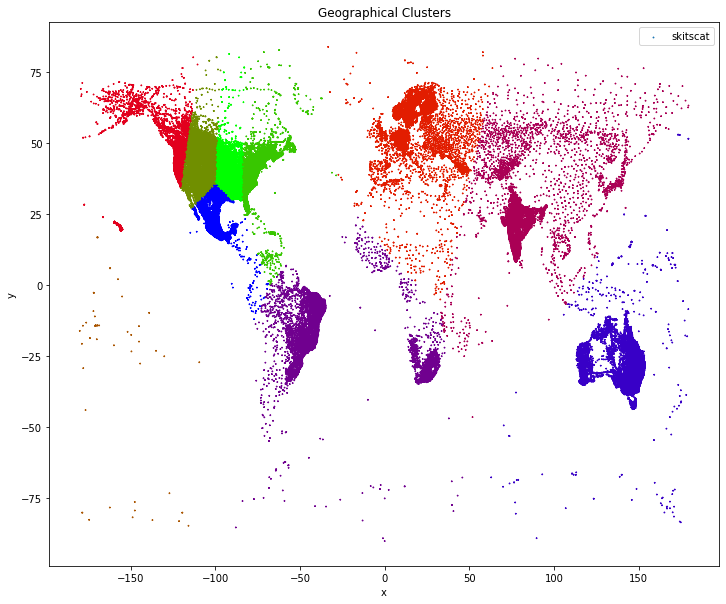

In [7]:
'''
Representing clusters using scatter plot
'''
import matplotlib.pyplot as plt

x1 = predictions.select("long").collect()
x = [float(row.long) for row in x1]

y1 = predictions.select("lat").collect()
y = [float(row.lat) for row in y1]

z1 = predictions.select("prediction").collect()
z = [int(row.prediction) for row in z1]

plt.figure(figsize=(12, 10))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Geographical Clusters')
plt.scatter(x,y, label='skitscat', c=z,cmap = "brg", s=1, marker="*")
plt.legend()
plt.show()

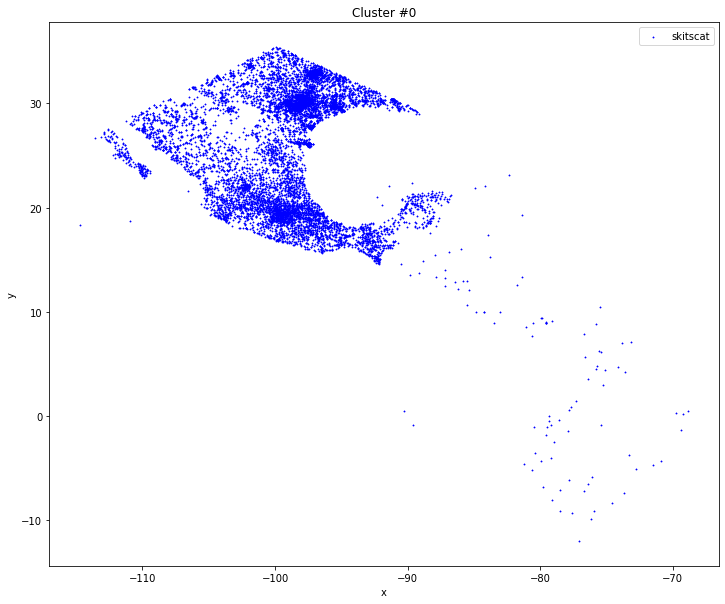

In [8]:
'''
Selecting one of the cluster to perform regression
'''

x1 = predictions.select("long").where(col("prediction")==0).collect()
x = [float(row.long) for row in x1]

y1 = predictions.select("lat").where(col("prediction")==0).collect()
y = [float(row.lat) for row in y1]

plt.figure(figsize=(12, 10))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Cluster #0')
plt.scatter(x,y, label='skitscat', c="b", s=1, marker="*")
plt.legend()
plt.show()

In [9]:
!wget ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/2019.csv.gz
!gzip -d 2019.csv.gz

--2020-06-12 17:03:58--  ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/2019.csv.gz
           => ‘2019.csv.gz’
Resolving ftp.ncdc.noaa.gov (ftp.ncdc.noaa.gov)... 205.167.25.137, 2610:20:8040:2::137
Connecting to ftp.ncdc.noaa.gov (ftp.ncdc.noaa.gov)|205.167.25.137|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/data/ghcn/daily/by_year ... done.
==> SIZE 2019.csv.gz ... 205092513
==> PASV ... done.    ==> RETR 2019.csv.gz ... done.
Length: 205092513 (196M) (unauthoritative)

2019.csv.gz         100%[===================>] 195.59M  35.1MB/s    in 16s     

2020-06-12 17:04:14 (12.6 MB/s) - ‘2019.csv.gz’ saved [205092513]



In [10]:
'''
Observatory data
'''

schema = StructType([StructField('id', StringType(), True),
                     StructField('date', DateType(), True),
                     StructField('measure', StringType(), True),
                     StructField('value', DoubleType(), True),StructField('extra', StringType(), True)])


data = spark.read.csv("./2019.csv",schema=schema,dateFormat="yyyyMMdd")
data.show(5)


+-----------+----------+-------+-----+-----+
|         id|      date|measure|value|extra|
+-----------+----------+-------+-----+-----+
|US1FLSL0019|2019-01-01|   PRCP|  0.0| null|
|US1FLSL0019|2019-01-01|   SNOW|  0.0| null|
|US1NVNY0012|2019-01-01|   PRCP|  0.0| null|
|US1NVNY0012|2019-01-01|   SNOW|  0.0| null|
|US1ILWM0012|2019-01-01|   PRCP|163.0| null|
+-----------+----------+-------+-----+-----+
only showing top 5 rows



In [11]:
predictionsForFirstCluster = predictions.select("id","lat","long","prediction").where(col("prediction")==0)

dataForFirstCluster = data.select("id","date","measure","value").where(col("measure")=="TMAX")\
.join(predictionsForFirstCluster,data['id']==predictionsForFirstCluster['id'])
dataForFirstCluster = dataForFirstCluster.drop(data['id']).cache()
dataForFirstCluster.show(5)
print(dataForFirstCluster.count())

+----------+-------+-----+-----------+-------+--------+----------+
|      date|measure|value|         id|    lat|    long|prediction|
+----------+-------+-----+-----------+-------+--------+----------+
|2019-01-01|   TMAX|161.0|USC00412173|29.0892|-97.3433|         0|
|2019-01-02|   TMAX|133.0|USC00412173|29.0892|-97.3433|         0|
|2019-01-03|   TMAX|122.0|USC00412173|29.0892|-97.3433|         0|
|2019-01-04|   TMAX|139.0|USC00412173|29.0892|-97.3433|         0|
|2019-01-05|   TMAX|206.0|USC00412173|29.0892|-97.3433|         0|
+----------+-------+-----+-----------+-------+--------+----------+
only showing top 5 rows

164139


In [12]:
data = dataForFirstCluster.drop(col("id")).drop(col("measure")).drop(col("lat")).drop("long")
data = data.groupBy(col("date")).agg(avg(col("value")).alias("mean_value"))
data.show(5)
print(data.count())

+----------+------------------+
|      date|        mean_value|
+----------+------------------+
|2019-05-08| 286.7796976241901|
|2019-06-04| 317.5034965034965|
|2019-09-22|321.60046728971963|
|2019-11-01|170.94965675057207|
|2019-11-18|219.63084112149534|
+----------+------------------+
only showing top 5 rows

365


In [13]:

import math
from pyspark.sql.functions import *
splitData = data\
    .withColumn("doy", dayofyear(col("date")))\
    .withColumn("doySin", sin((col("doy") / 365) * 2 * math.pi))\
    .withColumn("doyCos", cos((col("doy") / 365) * 2 * math.pi))\
    .withColumn("doySquare", col("doy") * col("doy"))\
    .select(col("date"), col("doy"),
      col("mean_value").alias("value"), col("doySquare"),
      col("doyCos"), col("doySin"))\
    .randomSplit([0.8, 0.2])

testData = splitData[1].cache()
trainData  = splitData[0].cache()

print(testData.count())
print(trainData.count())


75
290


290
290


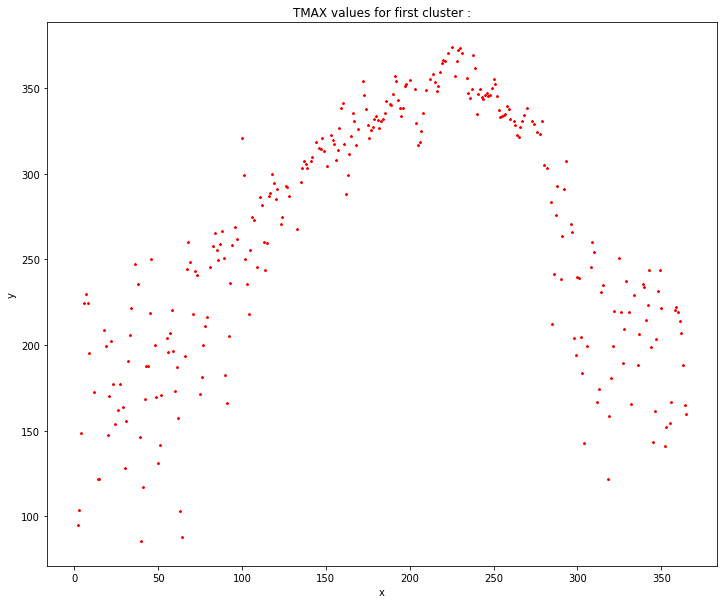

In [14]:
'''
Visualising the data for first cluster
'''

x1 = trainData.select("doy").collect()
x = [int(row.doy) for row in x1]
y1 = trainData.select("value").collect()
y = [float(row.value) for row in y1]
print(len(x))
print(len(y))

plt.figure(figsize=(12, 10))
plt.xlabel('x')
plt.ylabel('y')
plt.title('TMAX values for first cluster :')
plt.scatter(x,y, c='r', s=5, marker="*")
plt.show()

In [20]:
'''
TMAX Data looks parabolic / sinosoidal , So trying to fit these regressions
i.e. y = ax+bx^2 / asin(x)+bcos(x)
'''

from pyspark.ml.regression import LinearRegression

lrParabolaDataAssembler= VectorAssembler().setInputCols(["doy", "doySquare"]).setOutputCol("lrParabolaInput")

lrSinoSoidalDataAssembler = VectorAssembler().setInputCols(["doySin", "doyCos"]).setOutputCol("lrSinosoidalInput")

lrParabolaModel = LinearRegression()\
    .setFeaturesCol("lrParabolaInput")\
    .setLabelCol("value")\
    .setMaxIter(1000)\
    .setPredictionCol("predictedMaxTempParabola")

lrSinosoidalModel = LinearRegression()\
    .setFeaturesCol("lrSinosoidalInput")\
    .setLabelCol("value")\
    .setMaxIter(1000)\
    .setPredictionCol("predictedMaxTempSinosoidal")

lrParabolaModelTrained = lrParabolaModel.fit(lrParabolaDataAssembler.transform(trainData))
lrSinosoidalModeltrained = lrSinosoidalModel.fit(lrSinoSoidalDataAssembler.transform(trainData))

lrParabolaResult = lrParabolaModelTrained.transform(lrParabolaDataAssembler.transform(testData))
lrSinosoidalResult = lrSinosoidalModeltrained.transform(lrSinoSoidalDataAssembler.transform(testData))

lrParabolaResult.drop(col("doyCos")).drop("doySin").show(10)
lrSinosoidalResult.drop(col("doySquare")).show(10)

print(lrSinosoidalResult.count())
print(lrParabolaResult.count())

print("Coefficients for Parabola Model: " + str(lrParabolaModelTrained.coefficients))
print("Intercept for Parabola Model: " + str(lrParabolaModelTrained.intercept))

print("Coefficients for Sinosoidal Model: " + str(lrSinosoidalModeltrained.coefficients))
print("Intercept for Sinosoidal Model: " + str(lrSinosoidalModeltrained.intercept))


+----------+---+------------------+---------+----------------+------------------------+
|      date|doy|             value|doySquare| lrParabolaInput|predictedMaxTempParabola|
+----------+---+------------------+---------+----------------+------------------------+
|2019-11-01|305|170.94965675057207|    93025| [305.0,93025.0]|       262.3063738151101|
|2019-02-23| 54| 210.3282608695652|     2916|   [54.0,2916.0]|      207.81500006693955|
|2019-01-28| 28|191.67184035476717|      784|    [28.0,784.0]|      158.75100843769772|
|2019-07-30|211|349.65645514223195|    44521| [211.0,44521.0]|       330.8723771361013|
|2019-05-14|134| 282.8733905579399|    17956| [134.0,17956.0]|        307.656846157441|
|2019-07-28|209| 343.8775510204082|    43681| [209.0,43681.0]|      331.17369735739493|
|2019-05-10|130| 239.6039387308534|    16900| [130.0,16900.0]|      304.49751113214234|
|2019-03-11| 70|  214.863436123348|     4900|   [70.0,4900.0]|      233.95686748874982|
|2019-12-04|338|223.944444444444

In [21]:
#Evaluate Parabola model using metric like Mean Absolute Error(MAE), Root Mean Square Error(RMSE) and R-Square
from pyspark.ml.evaluation import RegressionEvaluator
evaluation = RegressionEvaluator(labelCol="value", predictionCol="predictedMaxTempParabola")

# Root Mean Square Error
rmse = evaluation.evaluate(lrParabolaResult, {evaluation.metricName: "rmse"})
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = evaluation.evaluate(lrParabolaResult, {evaluation.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = evaluation.evaluate(lrParabolaResult, {evaluation.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = evaluation.evaluate(lrParabolaResult, {evaluation.metricName: "r2"})
print("r2: %.3f" %r2)

RMSE: 41.707
MSE: 1739.512
MAE: 32.026
r2: 0.654


In [22]:
#Evaluate Parabola model using metric like Mean Absolute Error(MAE), Root Mean Square Error(RMSE) and R-Square
from pyspark.ml.evaluation import RegressionEvaluator
evaluation = RegressionEvaluator(labelCol="value", predictionCol="predictedMaxTempSinosoidal")

# Root Mean Square Error
rmse = evaluation.evaluate(lrSinosoidalResult, {evaluation.metricName: "rmse"})
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = evaluation.evaluate(lrSinosoidalResult, {evaluation.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = evaluation.evaluate(lrSinosoidalResult, {evaluation.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = evaluation.evaluate(lrSinosoidalResult, {evaluation.metricName: "r2"})
print("r2: %.3f" %r2)

RMSE: 34.267
MSE: 1174.226
MAE: 24.741
r2: 0.766


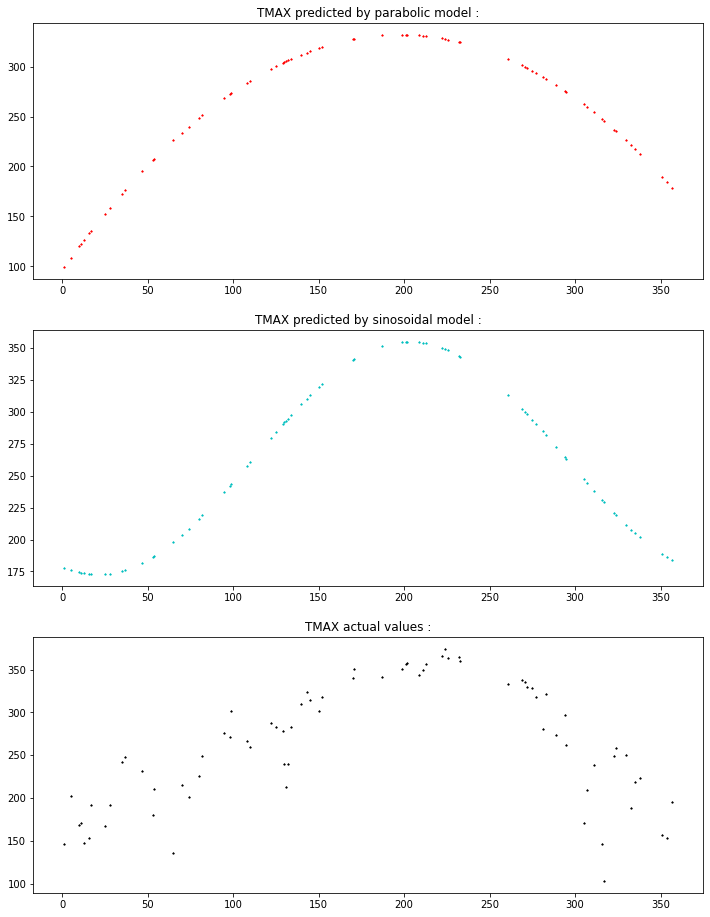

In [23]:
fig = plt.figure(figsize=(12,16))

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

x1 = lrParabolaResult.select("doy").collect()
x = [int(row.doy) for row in x1]

y1 = lrParabolaResult.select("predictedMaxTempParabola").collect()
resParaBolaY = [float(row.predictedMaxTempParabola) for row in y1]

y1 = lrSinosoidalResult.select("predictedMaxTempSinosoidal").collect()
resSinosoidalY = [float(row.predictedMaxTempSinosoidal) for row in y1]

y1 = testData.select("value").collect()
y = [float(row.value) for row in y1]

ax1.title.set_text('TMAX predicted by parabolic model :')
ax1.scatter(x,resParaBolaY, c='r', s=2, marker="*")
ax2.scatter(x,resSinosoidalY, c='c', s=2, marker="*")
ax2.title.set_text('TMAX predicted by sinosoidal model :')
ax3.scatter(x,y, c='k', s=2, marker="*")
ax3.title.set_text('TMAX actual values :')


